# About 
Results are loaded from the BSA code. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import pickle 

%matplotlib inline 

In [2]:
path_to_input = '../database/phi/sys.csv'
data = pd.read_csv(path_to_input)

In [3]:
data['axis_value'] = data['axis_min'] + 0.5 * (data['axis_max'] - data['axis_min'])

### Sources 
The file contains numerical sources which need to be correlated to string names that are contained in the file `systematic_sources.pkl` which is produced by the code `bsa.py`.

In [4]:
# Numerical names 
systematics = [col for col in data.columns if 'sys' in col and col != 'sys_total']
print('Systematics: ', systematics)

# String names 
with open('../systematic_sources.pkl', 'r') as inputfile:
    systematic_sources = pickle.load(inputfile)
    
for sys in systematics:
    print(sys, systematic_sources[sys])

('Systematics: ', ['sys_0', 'sys_1', 'sys_10', 'sys_11', 'sys_12', 'sys_13', 'sys_2', 'sys_3', 'sys_4', 'sys_5', 'sys_6', 'sys_7', 'sys_8', 'sys_9'])
('sys_0', 'beam_pol')
('sys_1', u'dist_dcr3')
('sys_10', u'missing_mass')
('sys_11', u'dist_ecu')
('sys_12', u'dist_cc')
('sys_13', u'dist_ecv')
('sys_2', u'dist_dcr1')
('sys_3', u'dist_vz')
('sys_4', u'dist_ecsf')
('sys_5', u'dist_ecw')
('sys_6', u'dist_ec_edep')
('sys_7', u'dvz')
('sys_8', u'p_mes')
('sys_9', u'alpha')


### Human Readable Names 
Here I will setup human readable names for the abbreviations used in the dictionary.  These are used during plotting. 

In [5]:
systematic_names = {}
systematic_names['beam_pol'] = 'Beam polarization'
systematic_names['dist_dcr1'] = 'Fid. DC R1'
systematic_names['dist_dcr3'] = 'Fid. DC R3'
systematic_names['dist_cc'] = 'Fid. CC'
systematic_names['dist_ecu'] = 'EC-U'
systematic_names['dist_ecv'] = 'EC-V'
systematic_names['dist_ecw'] = 'EC-W'
systematic_names['dist_vz'] = 'z-vertex'
systematic_names['dist_ecsf'] = 'Sampling fraction'
systematic_names['p_mes'] = 'Kaon momentum'
systematic_names['alpha'] = 'Confidence (Kaon ID)'
systematic_names['dist_ec_edep'] = 'EC energy deposition'
systematic_names['missing_mass'] = 'Missing mass'
systematic_names['dvz'] = 'eK vertex difference'

### Plotting Options 
Setup some basic plotting options.  Using the latex titles makes it slow.

In [6]:
plt.rc('font', family='serif')
plt.rc('font', size=16)
plt.rc('text', usetex=True)

### Plot Averaged Systematics 
This bar-plot shows for a given axis the relative contribution of each source.

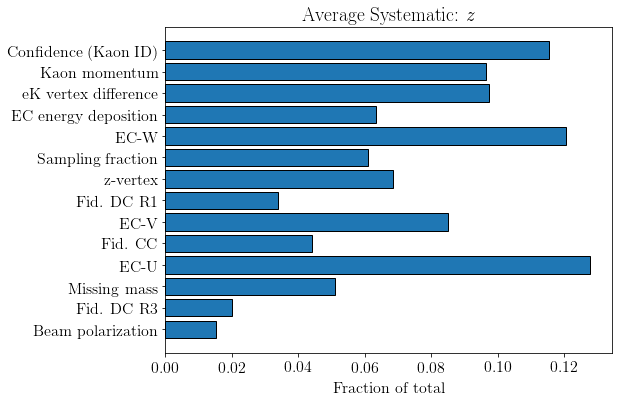

In [7]:
idx = np.where(data['axis'].values == 'z')
errs = [np.mean(np.abs(data.iloc[idx][s].values)) for s in systematics]
errs = np.abs(errs)
errs /= np.sum(errs)
names = [systematic_names[systematic_sources[s]] for s in systematics]

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.barh(names, errs, edgecolor='k')
ax.set_xlabel('Fraction of total')
ax.set_title('Average Systematic: $z$')
fig.savefig('../image/bar-systematics-z.pdf', bbox_inches='tight')

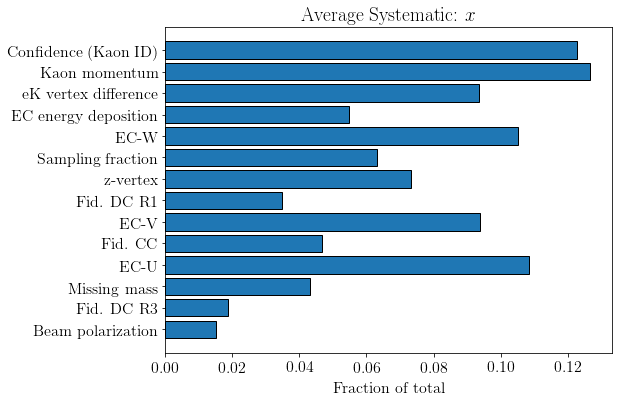

In [8]:
idx = np.where(data['axis'].values == 'x')
errs = [np.mean(np.abs(data.iloc[idx][s].values)) for s in systematics]
errs = np.abs(errs)
errs /= np.sum(errs)
names = [systematic_names[systematic_sources[s]] for s in systematics]

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.barh(names, errs, edgecolor='k')
ax.set_xlabel('Fraction of total')
ax.set_title('Average Systematic: $x$')
fig.savefig('../image/bar-systematics-x.pdf', bbox_inches='tight')

In [32]:
def grid_plot_one_axis(data, axis, display_sys=False):
    
    # First style 
    style = dict(
        linestyle='',
        marker='o',
        color='black'
    )
    
    # Make latex labels 
    tex_labels = {}
    tex_labels['x'] = 'x'
    tex_labels['z'] = 'z'
    tex_labels['q2'] = 'Q^2'
    tex_labels['pt'] = 'P_{T}^{2}'
    
    axis_data = data.iloc[np.where(data['axis'].values == axis)[0]]
    n_bins = axis_data['axis_bin'].nunique()

    n_cols = 3
    n_rows = int(np.floor(n_bins / n_cols) + 1)
    
    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, 
                            figsize = (4 * n_cols, 3 * n_rows),
                           sharex=True, sharey=True)
    fig.subplots_adjust(wspace=0, hspace=0)
        
    for irow in range(n_rows):
        for icol in range(n_cols):
            index = icol + irow * n_cols 
            
            bin_data = axis_data.iloc[np.where(axis_data['axis_bin'].values == index)[0]]

            if index < n_bins:
                label = '${0} \in [{1:.2f},{2:.2f}]$'.format(tex_labels[axis], 
                                                  bin_data['axis_min'].values[0],
                                                  bin_data['axis_max'].values[0])
                
                axs[irow, icol].errorbar(bin_data['phi'], 
                                         bin_data['value'], 
                                         bin_data['stat'], 
                                         **style)
                axs[irow, icol].set_ylim([-0.11, 0.11])
                axs[irow, icol].set_xlim([-190, 190])
                axs[irow, icol].axhline(0.0, linestyle='--', color='black', alpha=0.6)
                axs[irow, icol].text(0, 0.08, label)
                
                if display_sys:
                    phi_width = float(360.0 / len(bin_data))
                    axs[irow, icol].bar(bin_data['phi'], bin_data['sys_total'], 
                                        color='red', edgecolor='black', width=phi_width)
                
                # Left side of the plot 
                if icol % n_cols == 0:
                    axs[irow, icol].set_ylabel('BSA')
                
                # Bottom of the plot 
                if irow % n_rows == 0:
                    axs[irow, icol].set_xlabel('$\phi_h$')
        
    return fig, axs

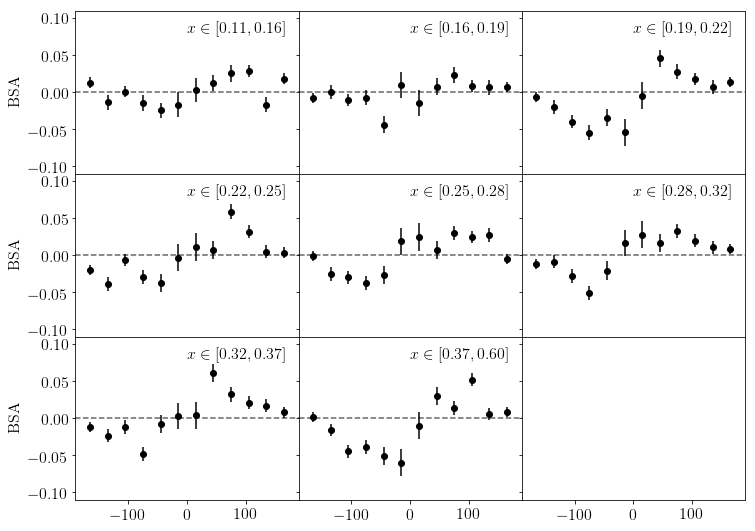

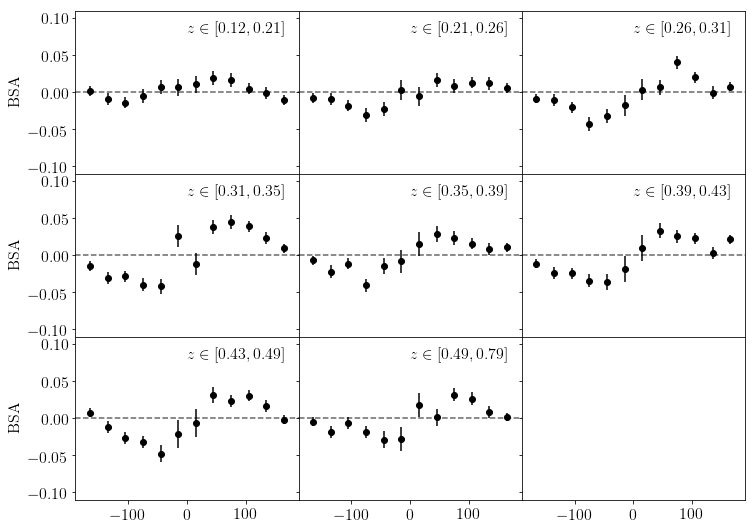

In [33]:
for axis in ['x', 'z']:
    fig, axs = grid_plot_one_axis(data, axis)
    plt.savefig('../image/grid_bsa_{}.pdf'.format(axis), bbox_inches='tight')

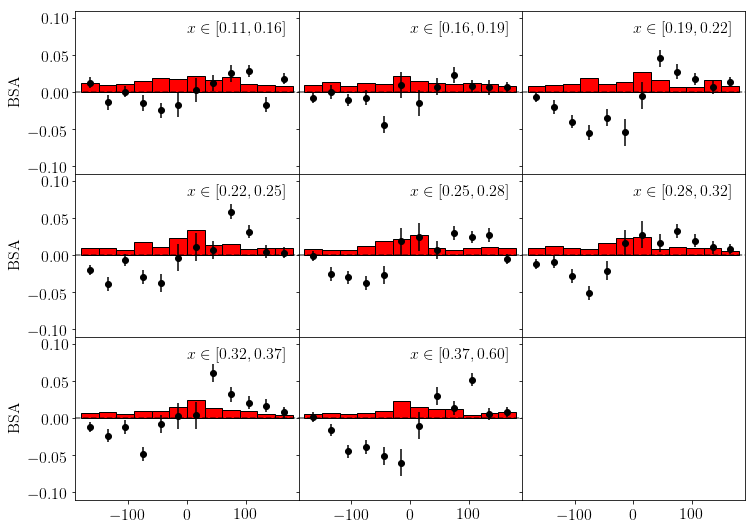

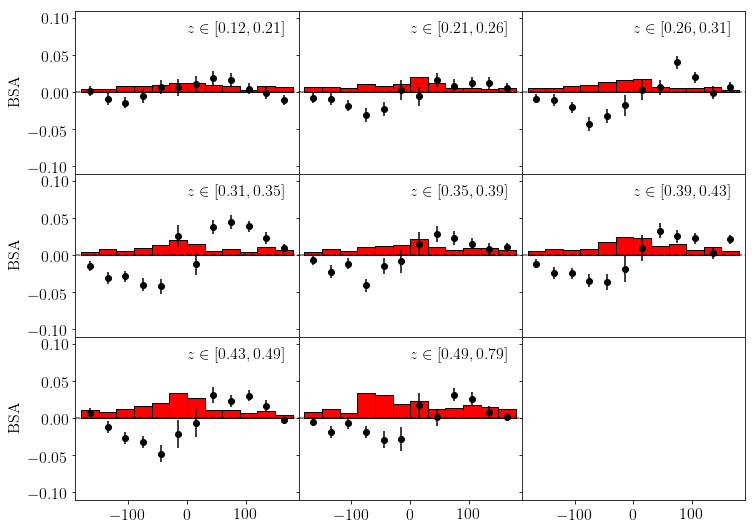

In [34]:
for axis in ['x', 'z']:
    fig, axs = grid_plot_one_axis(data, axis, display_sys=True)
    plt.savefig('../image/grid_bsa_sys_{}.pdf'.format(axis), bbox_inches='tight')

# Moments Extraction Results
In this section, the extraction results are loaded and visualized.  Before doing this, the file `results/fit/sys.csv` must be produced by the notebook called `systematics-fit` in the root directory of this project.

In [12]:
moments_df = pd.read_csv('../database/fit/sys.csv')
# moments_df = pd.read_csv('../results/fit/sys.csv')
moments_df.head()

,axis,axis_bin,axis_max,axis_min,bootstraps_0,bootstraps_1,bootstraps_2,err_0,err_1,err_2,par_0,par_1,par_2
0,missing_mass,0,1.433891,1.200002,[ 0.01419317 0.01040018 0.01791872 0.020189...,[ 0.10144165 -0.87383145 -0.19852833 -0.237817...,[ 0.3568361 -0.6807319 -0.15621802 0.007305...,0.005191,0.623682,0.507026,0.014598,-0.205403,-0.139767
1,missing_mass,1,1.540305,1.433891,[0.03539539 0.04867575 0.01617107 0.0439654 0...,[-0.54672986 -0.02097749 0.8191512 -0.369770...,[ 0.05900546 -0.39573297 -1. -0.343848...,0.011042,0.440849,0.424493,0.037473,-0.178354,-0.494488
2,missing_mass,2,1.644617,1.540305,[0.03226251 0.03490287 0.02419702 0.03375732 0...,[-0.79565704 -0.39166135 -1. -0.851457...,[-7.41922557e-01 -1.87850017e-02 2.92187154e-...,0.008209,0.487634,0.499897,0.031084,-0.464804,-0.136052
3,missing_mass,3,1.749693,1.644617,[0.02387666 0.01216768 0.03227985 0.03192171 0...,[-0.7063467 -0.17287748 -0.7531452 -0.622867...,[-0.6172347 0.78658795 -0.5094825 -0.727010...,0.006837,0.396431,0.650246,0.019362,-0.076973,0.187010
4,missing_mass,4,1.850798,1.749693,[0.03678777 0.03678831 0.02441409 0.03691017 0...,[-0.56911945 -0.73403805 -0.78449374 -0.625431...,[-0.2700993 -1. -0.70028186 -1. ...,0.009016,0.467055,0.567702,0.026716,-0.553945,-0.082379


In [13]:
print('Loaded table contains {} rows.'.format(len(moments_df)))

Loaded table contains 40 rows.


In [14]:
moments_df['axis_value'] = moments_df['axis_min'] + 0.5 * (moments_df['axis_max']-moments_df['axis_min'])

In [15]:
def find_systematic_contributions(columns, parameter_index):
    ''' Using the parameter index look through the columns 
    and return a list of the columns which are associated with
    this parameter systematics. '''
    return [c for c in columns if ('par{}'.format(parameter_index) in c and 'sys' in c)]

In [16]:
sys0_cols = find_systematic_contributions(moments_df.columns, 0)
sys1_cols = find_systematic_contributions(moments_df.columns, 1)
sys2_cols = find_systematic_contributions(moments_df.columns, 2)

In [17]:
print('Found ({},{},{}) sources for paramters (0,1,2).'.format(
    len(sys0_cols), len(sys1_cols), len(sys2_cols)))

Found (0,0,0) sources for paramters (0,1,2).


In [18]:
def add_sources_from_list(data, columns):
    ''' Take a list of sources and add them in quadrature. '''
    sum_squared = np.zeros(len(data))
    for col in columns:
        sum_squared += data[col]**2
        
    return np.sqrt(sum_squared)

In [19]:
moments_df['sys_total_0'] = add_sources_from_list(moments_df, sys0_cols)
moments_df['sys_total_1'] = add_sources_from_list(moments_df, sys1_cols)
moments_df['sys_total_2'] = add_sources_from_list(moments_df, sys2_cols)

In [20]:
# keeper_cols = ['axis', 'axis_value', 'par_0', 'err_0', 'sys_total_0']
# moments_df.drop(columns=[c for c in moments_df.columns if c not in keeper_cols], inplace=True)

In [21]:
moments_df.columns

Index([u'axis', u'axis_bin', u'axis_max', u'axis_min', u'bootstraps_0',
       u'bootstraps_1', u'bootstraps_2', u'err_0', u'err_1', u'err_2',
       u'par_0', u'par_1', u'par_2', u'axis_value', u'sys_total_0',
       u'sys_total_1', u'sys_total_2'],
      dtype='object')

### Plot Integrated Extraction

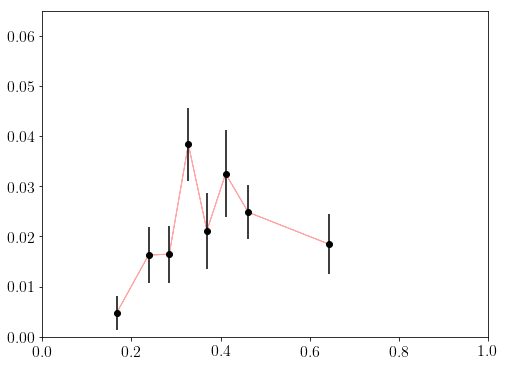

In [22]:
z_idx = np.where(moments_df['axis'].values == 'z')[0]

fig = plt.figure( figsize=(8,6) )
ax = fig.add_subplot(1,1,1)
ax.errorbar(moments_df.iloc[z_idx]['axis_value'], 
            moments_df.iloc[z_idx]['par_0'], 
            moments_df.iloc[z_idx]['err_0'],
           marker='o', linestyle='', color='black')
ax.set_ylim([0.0, 0.065])
ax.set_xlim([0.0, 1.0])

ax.fill_between(moments_df.iloc[z_idx]['axis_value'], 
       moments_df.iloc[z_idx]['par_0'] - moments_df.iloc[z_idx]['sys_total_0'],
       moments_df.iloc[z_idx]['par_0'] + moments_df.iloc[z_idx]['sys_total_0'],
               color='red', alpha=0.35, hatch='///')

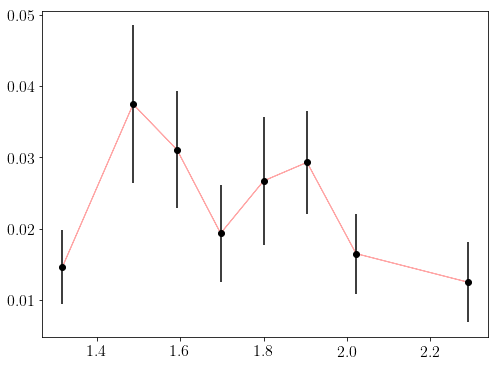

In [23]:
mm_idx = np.where(moments_df['axis'].values == 'missing_mass')[0]

fig = plt.figure( figsize=(8,6) )
ax = fig.add_subplot(1,1,1)
ax.errorbar(moments_df.iloc[mm_idx]['axis_value'], 
            moments_df.iloc[mm_idx]['par_0'], 
            moments_df.iloc[mm_idx]['err_0'],
           marker='o', linestyle='', color='black')
#ax.set_ylim([0.0, 0.065])
#ax.set_xlim([0.0, 1.0])

ax.fill_between(moments_df.iloc[mm_idx]['axis_value'], 
       moments_df.iloc[mm_idx]['par_0'] - moments_df.iloc[mm_idx]['sys_total_0'],
       moments_df.iloc[mm_idx]['par_0'] + moments_df.iloc[mm_idx]['sys_total_0'],
               color='red', alpha=0.35, hatch='///')

### Clean Dataframe
When loading the dataframe from `csv` format, the bootstrap columns get messed up.  Let's fix them and then look at one bin.

In [24]:
def fix_bootstrap_entry(x):
    return np.array([float(entry) for entry in x.strip('[').strip(']').split()])

In [25]:
moments_df['bootstraps_0'] = moments_df['bootstraps_0'].apply(fix_bootstrap_entry)
moments_df['bootstraps_1'] = moments_df['bootstraps_1'].apply(fix_bootstrap_entry)
moments_df['bootstraps_2'] = moments_df['bootstraps_2'].apply(fix_bootstrap_entry)

### Plot Bootstraps 
I currently have an issue with the first (lowest) z-bin.  Let's have a look at the phi-distributions and try overlaying the fit functions.  First, i'll define the function used to predict the data points based on our model parameter.  Then, i'll use the previously defined function for plotting the grid as a basis for our plot that includes the bootstrap replicas.

In [26]:
def physics_model(phi, par0, par1, par2):
    return par0 * np.sin(phi * np.pi / 180.0) / (1 + par1 * np.cos(phi * np.pi / 180.0) + par2 * np.cos(phi * np.pi / 90.0))

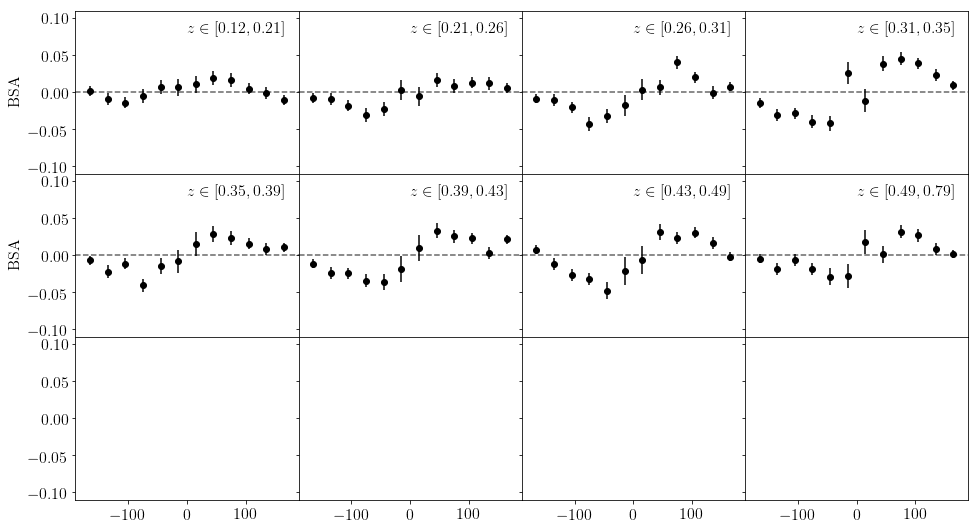

In [27]:
fig, axs = grid_plot_one_axis(data=data, axis='z')

In [28]:
def predict_replicas(moments_df, axis, axis_bin):
    ''' Accept a moments dataframe, subset it to the correct 
    axis and bin, then predict all the phi distributions. '''
    
    # setup phi for evaluation of function 
    phi = np.linspace(-180, 180, 20)
    
    # subset the data to just our bin 
    subset_idx = np.where(
        (moments_df['axis'] == axis) & (moments_df['axis_bin'] == axis_bin)
    )[0]
    data_subset = moments_df.iloc[subset_idx]
    assert(len(data_subset) > 0)
    
    replica_list = []
    
    for p0, p1, p2 in zip(data_subset.iloc[0]['bootstraps_0'],
                          data_subset.iloc[0]['bootstraps_1'],
                          data_subset.iloc[0]['bootstraps_2']):
        replica_list.append(
            physics_model(phi, p0, p1, p2)
        )
        
    replicas = np.array(replica_list)
    return replicas

In [29]:
def add_replicas_to_axis(axis, reps, style=dict()):
    ''' Take a matplotlib.axis object and add some 
    replica plots to it. '''
    phi = np.linspace(-180, 180, reps.shape[1])

    for rep in reps:
        axis.plot(phi, rep, **style)

In [37]:
def grid_plot_one_axis_with_replicas(data, moments=None, axis='z', display_sys=False):
    
    # First style 
    style = dict(
        linestyle='',
        marker='o',
        color='black'
    )
    
    # Reps style
    rep_style = dict(
        linestyle = '-',
        color = 'red',
        alpha = 0.01
    )
    
    # Make latex labels 
    tex_labels = {}
    tex_labels['x'] = 'x'
    tex_labels['z'] = 'z'
    tex_labels['q2'] = 'Q^2'
    tex_labels['pt'] = 'P_{T}^{2}'
    tex_labels['missing_mass'] = 'M_{X}'
    
    axis_data = data.iloc[np.where(data['axis'].values == axis)[0]]
    n_bins = axis_data['axis_bin'].nunique()

    n_cols = 3
    n_rows = int(np.floor(n_bins / n_cols) + 1)
    
    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, 
                            figsize = (4 * n_cols, 3 * n_rows),
                           sharex=True, sharey=True)
    fig.subplots_adjust(wspace=0, hspace=0)
        
    for irow in range(n_rows):
        for icol in range(n_cols):
            index = icol + irow * n_cols 
            
            bin_data = axis_data.iloc[np.where(axis_data['axis_bin'].values == index)[0]]

            if index < n_bins:
                label = '${0} \in [{1:.2f},{2:.2f}]$'.format(tex_labels[axis], 
                                                  bin_data['axis_min'].values[0],
                                                  bin_data['axis_max'].values[0])
                
                axs[irow, icol].errorbar(bin_data['phi'], 
                                         bin_data['value'], 
                                         bin_data['stat'], 
                                         **style)
                axs[irow, icol].set_ylim([-0.11, 0.11])
                axs[irow, icol].set_xlim([-190, 190])
                axs[irow, icol].axhline(0.0, linestyle='--', color='black', alpha=0.6)
                axs[irow, icol].text(0, 0.08, label)
                
                if moments is not None:
                    reps = predict_replicas(moments, axis, index)
                    add_replicas_to_axis(axs[irow, icol], reps, rep_style)
                
                if display_sys:
                    phi_width = float(360.0 / len(bin_data))
                    axs[irow, icol].bar(bin_data['phi'], bin_data['sys_total'], 
                                        color='red', edgecolor='black', width=phi_width)
                
                # Left side of the plot 
                if icol % n_cols == 0:
                    axs[irow, icol].set_ylabel('BSA')
                
                # Bottom of the plot 
                if irow % n_rows == 0:
                    axs[irow, icol].set_xlabel('$\phi_h$')
        
    return fig, axs

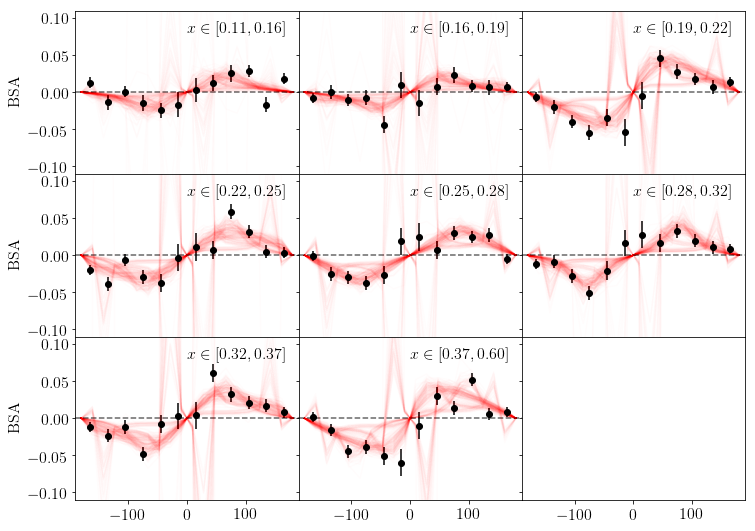

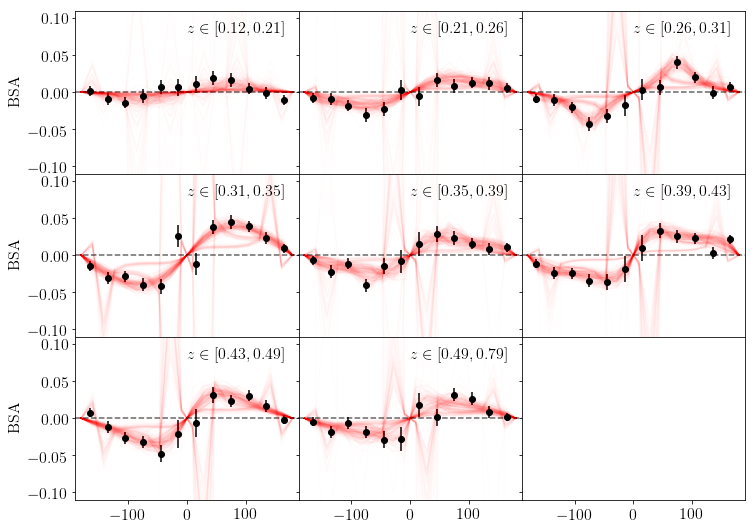

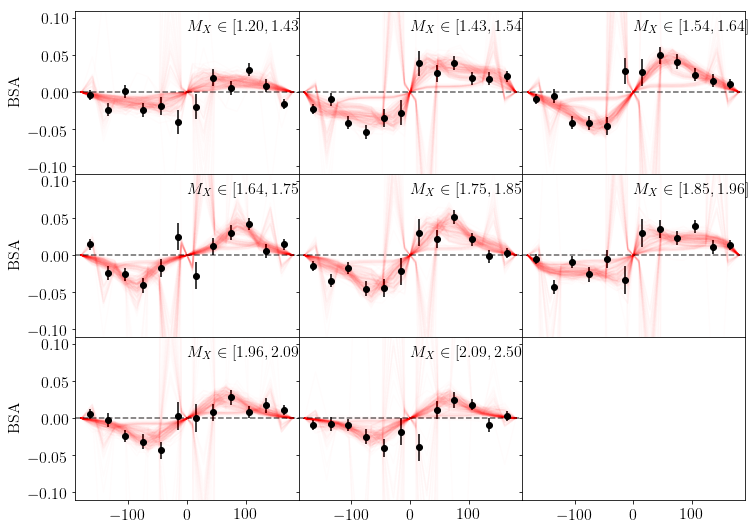

In [38]:
for axis in list(['x', 'z', 'missing_mass']):
    grid_plot_one_axis_with_replicas(data, moments_df, axis, display_sys=False)
    plt.savefig('../image/grid_bsa_reps_{}.pdf'.format(axis), bbox_inches='tight')